## Sentiment Analysis of IMDB Movie Reviews

In [1]:
#Load the libraries
!pip install transformers
import os
import re
import nltk
import spacy
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from transformers import DistilBertTokenizer, AutoTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split
from transformers import DistilBertForSequenceClassification, TFDistilBertModel
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer


# from sklearn.preprocessing import LabelBinarizer

# from nltk.tokenize import word_tokenize,sent_tokenize
# import re,string,unicodedata

# from nltk.stem import LancasterStemmer,WordNetLemmatizer
# from sklearn.linear_model import LogisticRegression,SGDClassifier
# 
# from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.1 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 45.0 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Datasets

In [2]:
df=pd.read_csv('IMDB_Dataset.csv')
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Load the libraries

import os
import re
import nltk
import spacy
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from transformers import DistilBertTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer


# from sklearn.preprocessing import LabelBinarizer

# from nltk.tokenize import word_tokenize,sent_tokenize
# import re,string,unicodedata

# from nltk.stem import LancasterStemmer,WordNetLemmatizer
# from sklearn.linear_model import LogisticRegression,SGDClassifier
# 
# from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Datasets

In [4]:
df=pd.read_csv('IMDB_Dataset.csv')
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Extract basic info from the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
# Find missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

#### Checking for duplicate reviews

In [8]:
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [9]:
#view duplicate reviews
duplicated_review = df['review']
duplicated_review = df[duplicated_review.isin(duplicated_review[duplicated_review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [10]:
#drop duplicate reviews
df.drop_duplicates(inplace = True)

In [11]:
# This checks for data imbalance
print('positive consists of', round(df['sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('negative consists of', round(df['sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

positive consists of 50.19 % of the dataset
negative consists of 49.81 % of the dataset


#### Investigate what kind of special characters used by the reviewers to review the content. 

In [12]:
review = df['review'].loc[10]
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

##### It can be observed that the data has html tags, special characters, uppercase(not necessary when using stopwords)

# Data Cleaning

#### Here we will remove html contents, special characters, uppercases, whitespaces, stopwords and other unwanted stuff as they can decrease the model accuracy.

In [13]:
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

#### removing html contents

In [14]:
def remove_html_tags(text):
    text=re.sub('<.*?>',' ',text)
    return text
review = remove_html_tags(review)
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.  At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.  Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.  I imagine this film would appeal to a stoner who is currently partaking.  For something similar but better try "Brother from another planet"'

#### removing special characters

In [15]:
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    text = re.sub('\[[^]]*\]', '', text)
    return text
review = remove_special_characters(review)
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines  At first it was very odd and pretty funny but as the movie progressed I didnt find the jokes or oddness funny anymore  Its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually I just lost interest  I imagine this film would appeal to a stoner who is currently partaking  For something similar but better try Brother from another planet'

#### Convert to lowercase

In [16]:
def to_lowercase(text):
    return text.lower()
review = to_lowercase(review)
review

'phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines  at first it was very odd and pretty funny but as the movie progressed i didnt find the jokes or oddness funny anymore  its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually i just lost interest  i imagine this film would appeal to a stoner who is currently partaking  for something similar but better try brother from another planet'

#### unify whitespaces

In [17]:
def unify_whitespaces(text):  
    text = re.sub(" +", " ", text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    return text
review = unify_whitespaces(review)
review

'phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines at first it was very odd and pretty funny but as the movie progressed i didnt find the jokes or oddness funny anymore its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually i just lost interest i imagine this film would appeal to a stoner who is currently partaking for something similar but better try brother from another planet'

#### removing the stopwords

In [18]:
def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    return ' '.join(text)
review = remove_stopwords(review)
review

'phil alien one quirky films humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed didnt find jokes oddness funny anymore low budget film thats never problem pretty interesting characters eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

#### Stemming the text

In [19]:
def text_stemming(text):
    ps = PorterStemmer()
    text = text.split()
    text = [ps.stem(word) for word in text]
    return ' '.join(text) 
stem_review = text_stemming(review)
stem_review

'phil alien one quirki film humour base around odd everyth rather actual punchlin first odd pretti funni movi progress didnt find joke odd funni anymor low budget film that never problem pretti interest charact eventu lost interest imagin film would appeal stoner current partak someth similar better tri brother anoth planet'

#### Lemmatizing the text

In [20]:
def text_lemmatizing(text):
    lem = WordNetLemmatizer()
    text = text.split()
    text = [lem.lemmatize(word) for word in text]
    return ' '.join(text) 
lem_review = text_lemmatizing(review)
lem_review

'phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed didnt find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

#### From the result of both stemming and lemmatizing shows lemmatizing to still retain the structure of the reviews better that stemming 

In [21]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [22]:
def preprocessing(df, lemmatize = True):
    df['review']=df['review'].apply(remove_html_tags)
    df['review']=df['review'].apply(remove_special_characters)
    df['review']=df['review'].apply(to_lowercase)
    df['review']=df['review'].apply(unify_whitespaces)
    df['review']=df['review'].apply(remove_stopwords)
    if lemmatize:
        df['review']=df['review'].apply(text_lemmatizing)
    return df
df_final = preprocessing(df)



In [ ]:
df_final.review[10]

'phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed didnt find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

# Label encoding 

In [ ]:
label_encoder = LabelEncoder()
df_final['sentiment'] = label_encoder.fit_transform(df_final['sentiment'])

# Exploratory Data Analysis

#### Word summary of positive reviews

(-0.5, 399.5, 199.5, -0.5)

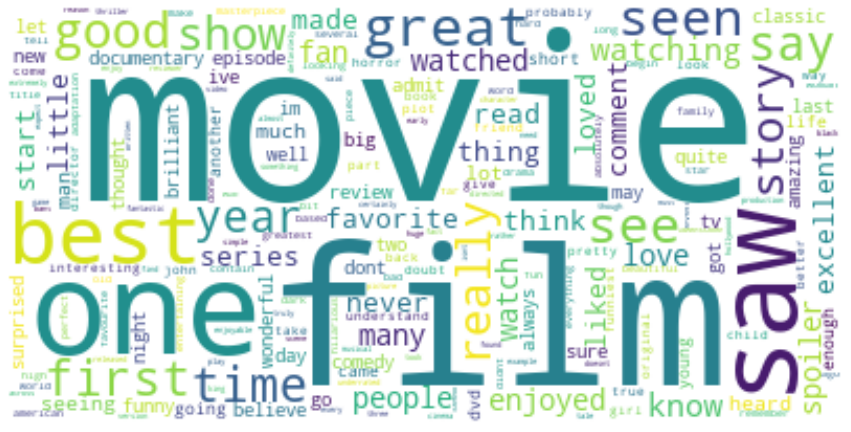

In [ ]:
positive =  df_final[df_final['sentiment'] == 1]

text = " ".join(cat.split()[1] for cat in positive.review)
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

#### Word summary of negative reviews

(-0.5, 399.5, 199.5, -0.5)

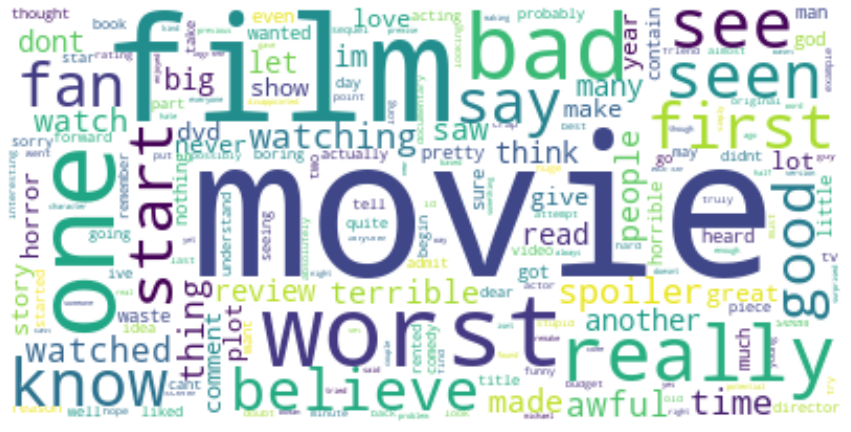

In [ ]:
negative =  df_final[df_final['sentiment'] == 0]

text = " ".join(cat.split()[1] for cat in negative.review)
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

#### Number of words in text for each label

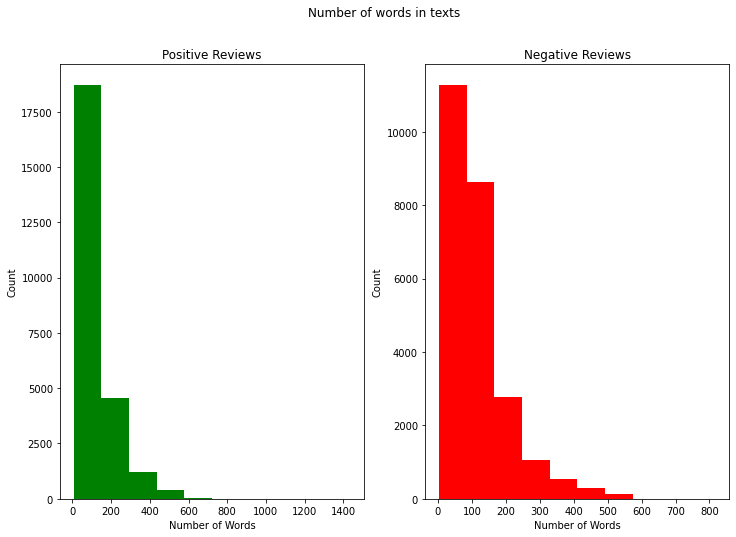

In [ ]:
positive_data =  df_final[df_final['sentiment'] == 1]['review']
negative_data =  df_final[df_final['sentiment'] == 0]['review']
positive_data_string = ' '.join(positive_data)
negative_data_string = ' '.join(negative_data)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_final.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', '1']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,100172
1,film,90935
2,one,53397
3,like,39681
4,time,29978
5,good,28823
6,character,27747
7,story,24566
8,even,24380
9,get,24322


In [ ]:
most_common = most_common.sort_values('countv')

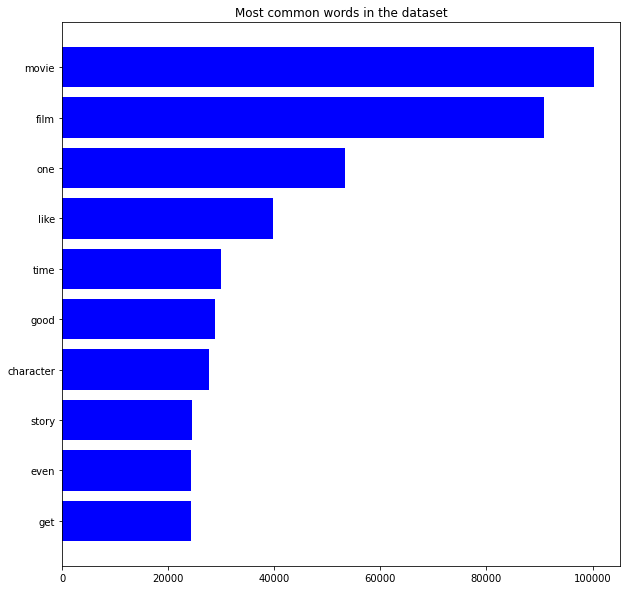

In [ ]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [ ]:
df_semi = df_final

## Split the data into test and train dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_final.review, df_final.sentiment, test_size=0.30, random_state=2)

#### Here 70% of the data is taken as training data and 30% is used for testing 

# Word Vectorization

In [ ]:
#Count vectorizer for bag of words
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#### Note that it contains 50k rows so its a mid-sized database so we expect the TF-IDF based model to work better than deep learning models. We will use pre-built TF-IDF vectorizer from sklearn library. 

In [ ]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))

# Modelling

In [ ]:
# modelling
LR = LogisticRegression()
pipeline = make_pipeline(vectorizer, LR)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(predict, y_test)
print("LR = " + str('{:04.2f}'.format(accuracy*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

LR = 89.30 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.89      7390
    Positive       0.88      0.91      0.90      7485

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875

Confusion Matrix: 
 [[6469  921]
 [ 670 6815]]


In [ ]:
MNB = MultinomialNB()
pipeline = make_pipeline(vectorizer, MNB)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)


In [ ]:
accuracy = accuracy_score(predict, y_test)
print("Multinomial Naive Bayes accuracy = " + str('{:04.2f}'.format(accuracy*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Multinomial Naive Bayes accuracy = 88.79 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.88      0.89      0.89      7390
    Positive       0.89      0.88      0.89      7485

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875

Confusion Matrix: 
 [[6598  792]
 [ 875 6610]]


In [ ]:
SGDC = SGDClassifier()
pipeline = make_pipeline(vectorizer, SGDC)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)
accuracy = accuracy_score(predict, y_test)
print("Stocastic Gradient Classifier accuracy = " + str('{:04.2f}'.format(accuracy*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Stocastic Gradient Classifier accuracy = 89.72 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.89      7390
    Positive       0.88      0.92      0.90      7485

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875

Confusion Matrix: 
 [[6484  906]
 [ 623 6862]]


In [ ]:
# Linear SVM¶
LSVC = LinearSVC()
pipeline = make_pipeline(vectorizer, LSVC)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)


In [ ]:
accuracy = accuracy_score(predict, y_test)
print("Linear SVC accuracy = " + str('{:04.2f}'.format(accuracy*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Linear SVC accuracy = 90.98 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      7390
    Positive       0.90      0.92      0.91      7485

    accuracy                           0.91     14875
   macro avg       0.91      0.91      0.91     14875
weighted avg       0.91      0.91      0.91     14875

Confusion Matrix: 
 [[6625  765]
 [ 577 6908]]


#### The above metric shows the Accuracy, Sensitivity, precision in confusion matrix. Classification report shows that the performance of the model is not bad. Accuracy as a metric may be misleading sometimes. However here the accuracy, precision and recall are almost similar. So accuracy can be the major evaluation metric

#### Accuracy is 90.98%

Precision: Out of all the sentiments that the model predicted Positive, only 90% actually did.

Recall / Sensitivity: Out of all the sentiments that actually did get positiv reviews, the model only predicted this outcome correctly for 92% of those time.

Support: is the number of occurence of the given class in your dataset (here 7499 of Negative and 7485 of Positive, which is a really well balanced dataset)

Here the model has a high False positive value
#### NB: precision and recall is mostly used for imbalanced dataset because in an highly imbalanced dataset. So here we will be focusing on accuracy score majorly since the dataset is balanced.

# Save model and tfidf 

In [ ]:
# save your model in disk
joblib.dump(pipeline, 'Models/model.pkl')

['Models/model.pkl']

In [ ]:
def tfidf_preprocessing(text):
    text =remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    text = unify_whitespaces(text)
    text = remove_stopwords(text)
    return text

In [ ]:
text = "Good review"
text = tfidf_preprocessing(text)
text

'good review'

In [ ]:
# Load the model from the file
# model = joblib.load('Models/model.pkl')
 
# Use the loaded model to make predictions
model.predict([text])

array([0])

# Deep Learning Approach

In [23]:
# Check if there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
df_dp = preprocessing(df, lemmatize = False)

In [25]:
df_dp

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


In [26]:
train, test= train_test_split(df_dp, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

label_encoder = LabelEncoder()
ytrain = label_encoder.fit_transform(ytrain)
ytest  = label_encoder.fit_transform(ytest)

#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval = train_test_split(Xtrain,ytrain,
                                             test_size=0.2,random_state=10)

In [27]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [28]:
max_seq_len = 128
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [29]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [30]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [31]:
transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [32]:
epochs = 3
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=None                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
992/992 [==============================] - 455s 449ms/step - loss: 0.3374 - accuracy: 0.8498 - val_loss: 0.2660 - val_accuracy: 0.8883
Epoch 2/3
992/992 [==============================] - 447s 450ms/step - loss: 0.2177 - accuracy: 0.9129 - val_loss: 0.2823 - val_accuracy: 0.8883
Epoch 3/3
992/992 [==============================] - 141s 142ms/step - loss: 0.0489 - accuracy: 0.9851
Train score: [0.04889998212456703, 0.9850624203681946]
248/248 [==============================] - 35s 142ms/step - loss: 0.3422 - accuracy: 0.8916
Validation score: [0.3422398865222931, 0.8915920853614807]


In [34]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

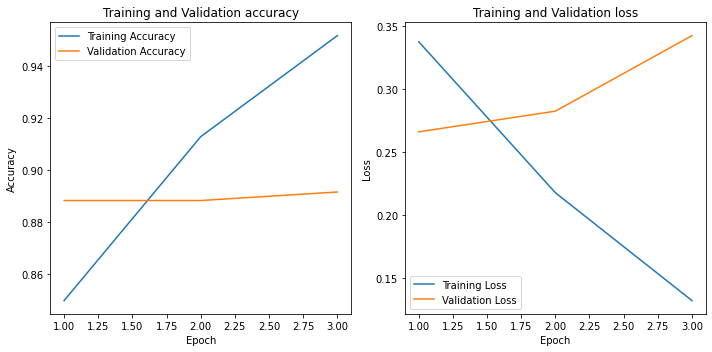

In [35]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [36]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 42s 136ms/step - loss: 0.3597 - accuracy: 0.8861
{'loss': 0.3596540689468384, 'accuracy': 0.886054277420044}


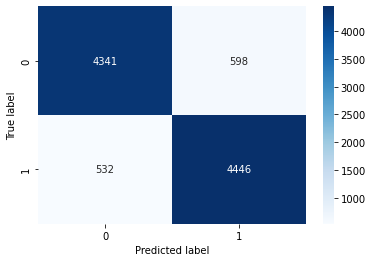

In [37]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()